In [1]:
import os, sys
from pathlib import Path
import yaml
import torch
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

# Make project imports work (in notebooks __file__ is undefined)
ROOT = Path.cwd()
sys.path.append(str(ROOT))

from src.training.rgba_vae_stage import build_dataloader  # noqa: E402

# Load config
cfg_path = ROOT / "configs/flux_vae.yaml"
with cfg_path.open("r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

# Force a small batch for quick visual checks
cfg.setdefault("data", {})
cfg["data"]["batch_size"] = 16
cfg["data"]["shuffle"] = True  # enable shuffle for probing
cfg["data"]["interleave_buckets"] = True  # mix buckets instead of draining one-by-one

# Build dataloader on CPU
train_loader = build_dataloader(cfg, split="train")
print("Dataloader ready. Batches:", len(train_loader) if hasattr(train_loader, "__len__") else "unknown")


Dataloader ready. Batches: 177025


In [2]:
from collections import Counter
from src.data_generation.bucket_dataset import BucketBatchSampler

# Bucket size stats
bucket_counts = {k: len(v) for k, v in train_loader.dataset.bucket_to_indices.items()}
total_entries = sum(bucket_counts.values())
print("Total entries:", total_entries)
for b, c in sorted(bucket_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"bucket {b:>12}: {c} samples ({c/total_entries:.3%})")

# Simulate sampler order without loading images
num_batches_probe = 200
sampler = BucketBatchSampler(
    train_loader.dataset.bucket_to_indices,
    batch_size=cfg["data"]["batch_size"],
    shuffle=True,
    drop_last=bool(cfg["data"].get("drop_last", False)),
    interleave=True,
)
probe = Counter()
for i, batch_idxs in enumerate(sampler):
    bname = train_loader.dataset.entries[batch_idxs[0]]["bucket"]
    probe[bname] += 1
    if i + 1 >= num_batches_probe:
        break
print("--- First", num_batches_probe, "batches bucket frequency (with shuffle=True)")
for b, c in sorted(probe.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"bucket {b:>12}: {c} batches")


Total entries: 2831275
bucket  w1024-h1024: 2058520 samples (72.706%)
bucket   w960-h1152: 286172 samples (10.108%)
bucket   w832-h1024: 274737 samples (9.704%)
bucket   w768-h1408: 61603 samples (2.176%)
bucket   w832-h1280: 35790 samples (1.264%)
bucket   w1024-h832: 18288 samples (0.646%)
bucket   w1408-h768: 9933 samples (0.351%)
bucket   w1280-h832: 5546 samples (0.196%)
bucket    w768-h512: 4582 samples (0.162%)
bucket   w1216-h896: 4181 samples (0.148%)
bucket    w576-h576: 3924 samples (0.139%)
bucket    w768-h576: 3517 samples (0.124%)
bucket    w768-h768: 3182 samples (0.112%)
bucket   w1024-h704: 2945 samples (0.104%)
bucket   w1024-h640: 2731 samples (0.096%)
bucket   w896-h1216: 2620 samples (0.093%)
bucket   w1024-h768: 2445 samples (0.086%)
bucket   w704-h1024: 2064 samples (0.073%)
bucket    w576-h896: 2033 samples (0.072%)
bucket    w576-h768: 2022 samples (0.071%)
bucket    w640-h640: 2022 samples (0.071%)
bucket    w960-h768: 1466 samples (0.052%)
bucket   w768-h1024

--- First 200 batches bucket frequency (with shuffle=True)
bucket  w1024-h1024: 150 batches
bucket   w960-h1152: 23 batches
bucket   w832-h1024: 12 batches
bucket   w768-h1408: 5 batches
bucket   w832-h1280: 4 batches
bucket   w1024-h832: 3 batches
bucket    w576-h896: 1 batches
bucket    w896-h896: 1 batches
bucket    w640-h768: 1 batches


In [3]:
import math

def to_checkerboard_grid(rgba: torch.Tensor, nrow: int = 4, tile: int = 16):
    """Compose RGBA onto a checkerboard and return a grid tensor in [0,1]."""
    if rgba.dim() == 3:
        rgba = rgba.unsqueeze(0)
    assert rgba.shape[1] >= 4, "Expected RGBA input"
    rgb = rgba[:, :3]
    alpha = rgba[:, 3:4]

    # If values look like [-1,1], map to [0,1]
    if rgb.min() < -0.01 or rgb.max() > 1.01 or alpha.min() < -0.01 or alpha.max() > 1.01:
        rgb = (rgb + 1.0) * 0.5
        alpha = (alpha + 1.0) * 0.5

    rgb = rgb.clamp(0.0, 1.0)
    alpha = alpha.clamp(0.0, 1.0)

    _, _, h, w = rgb.shape
    y = torch.arange(h).view(-1, 1)
    x = torch.arange(w).view(1, -1)
    pattern = ((y // tile + x // tile) % 2).to(dtype=rgb.dtype)
    pattern = pattern * 0.9 + 0.1
    checker = pattern.unsqueeze(0).repeat(3, 1, 1)  # (3, H, W)
    checker = checker.unsqueeze(0).repeat(rgb.shape[0], 1, 1, 1)

    composed = rgb * alpha + checker * (1.0 - alpha)
    return make_grid(composed, nrow=nrow, padding=2)


def get_batch(loader, idx: int):
    for i, batch in enumerate(loader):
        if i == idx:
            return batch
    raise IndexError(f"batch {idx} out of range")


Batch shape: torch.Size([16, 4, 1024, 832])
Min/Max: 0.0 1.0


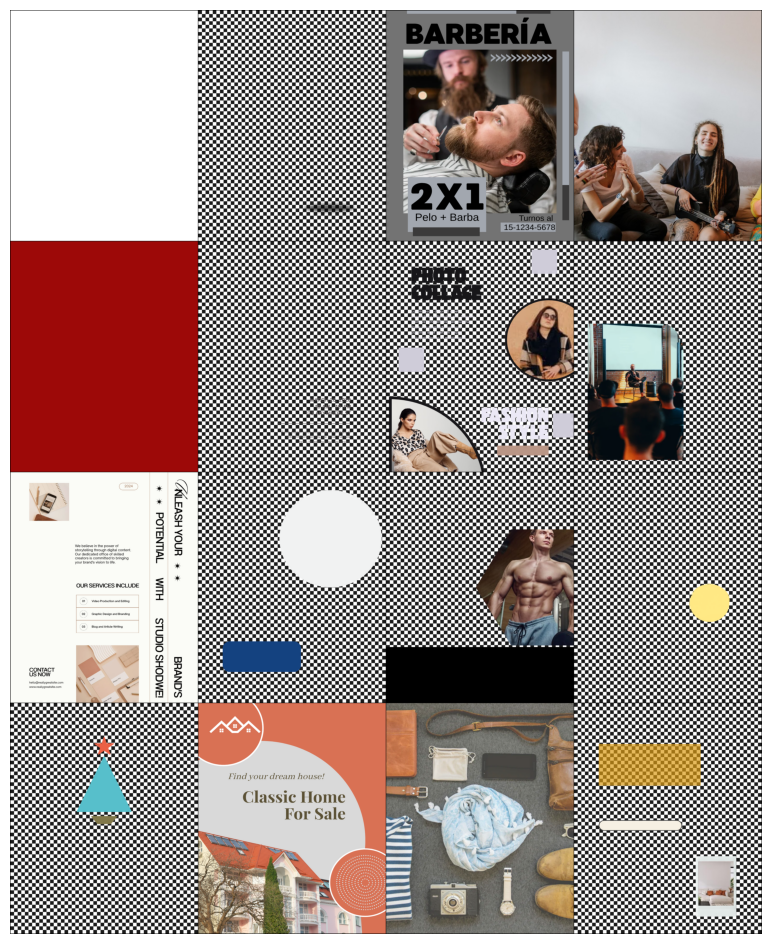

In [4]:
# Change this to step through batches
batch_idx = 1  # e.g., 0, 1, 2...
nrow = 4       # 4 x 4 grid for 16 examples

batch = get_batch(train_loader, batch_idx)
rgba = batch.get("composite")
if rgba is None:
    rgba = batch.get("component")
if rgba is None:
    raise ValueError("Batch missing 'composite' or 'component' tensor")

print("Batch shape:", rgba.shape)
print("Min/Max:", rgba.min().item(), rgba.max().item())

grid = to_checkerboard_grid(rgba, nrow=nrow)
plt.figure(figsize=(12, 12))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()


In [5]:
from collections import Counter, defaultdict
from pathlib import Path
import yaml
from src.data_generation.bucket_dataset import build_bucket_entries, MixedBucketDataset

cfg = yaml.safe_load(open("configs/flux_vae.yaml"))
data_cfg = cfg["data"]
split = data_cfg.get("bucket_split", "train")
ds_cfgs = data_cfg.get("bucket_datasets", [])

# 엔트리 생성
entries = build_bucket_entries(ds_cfgs, split=split)
print("total entries:", len(entries))

# 데이터셋별 크기 (root 폴더명 기준으로 구분)
by_dataset = Counter(Path(e["root_dir"]).name for e in entries)
print("per dataset counts:", by_dataset)

# 버킷별 크기
by_bucket = Counter(e["bucket"] for e in entries)
print("bucket count (top 10):", by_bucket.most_common(10))

# 버킷별 비율
total = len(entries)
bucket_probs = {b: c/total for b, c in by_bucket.items()}
print("bucket prob (top 10):", sorted(bucket_probs.items(), key=lambda x: x[1], reverse=True)[:10])

total entries: 2831275
per dataset counts: Counter({'lica_250k': 2651409, 'laion1M_aethtetic': 96113, 'prism_layer_pro': 80184, 'prism_layer_real': 3569})
bucket count (top 10): [('w1024-h1024', 2058520), ('w960-h1152', 286172), ('w832-h1024', 274737), ('w768-h1408', 61603), ('w832-h1280', 35790), ('w1024-h832', 18288), ('w1408-h768', 9933), ('w1280-h832', 5546), ('w768-h512', 4582), ('w1216-h896', 4181)]
bucket prob (top 10): [('w1024-h1024', 0.7270646616806916), ('w960-h1152', 0.10107531059328395), ('w832-h1024', 0.09703649415899197), ('w768-h1408', 0.02175804187159495), ('w832-h1280', 0.012640947982799269), ('w1024-h832', 0.006459280712753088), ('w1408-h768', 0.0035083133923762264), ('w1280-h832', 0.0019588348005757125), ('w768-h512', 0.0016183521558308536), ('w1216-h896', 0.0014767198523633345)]


# model load

In [5]:

from src.models import RgbaVAE, composite_over_black

# Resolve device and subfolder for flux/qwen variants
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_model_cfg = cfg.get("model", {})
_base_arch = str(_model_cfg.get("base_arch", "qwen")).lower()
_default_subfolder = "ae" if "flux" in _base_arch else "vae"
_subfolder = _model_cfg.get("rgb_subfolder")
_subfolder = _default_subfolder if _subfolder is None else _subfolder
_ckpt_dir = _model_cfg.get("rgb_checkpoint", "checkpoints/flux_rgba_vae_init")

_dtype =  torch.float32
model = RgbaVAE.from_pretrained_rgb(
    model_name_or_path=_ckpt_dir,
    subfolder=_subfolder,
    torch_dtype=_dtype,
    alpha_bias_init=_model_cfg.get("alpha_bias_init", 0.0),
    beta=_model_cfg.get("beta", 0.25),
    alpha_loss_weight=_model_cfg.get("alpha_loss_weight", 1.0),
    alpha_l1_weight=_model_cfg.get("alpha_l1_weight", 0.0),
    rgb_loss_weight=_model_cfg.get("rgb_loss_weight", 1.0),
    white_bg_weight=_model_cfg.get("white_bg_loss_weight", 0.0),
    black_bg_weight=_model_cfg.get("black_bg_loss_weight", 0.0),
    device=_device,
)
model.eval();

with torch.no_grad():
    recon, _ = model(rgba.to(device=_device, dtype=_dtype))
recon = recon.cpu()

recon_grid = to_checkerboard_grid(recon, nrow=nrow)
plt.figure(figsize=(12, 12))
plt.imshow(recon_grid.permute(1, 2, 0).numpy())
plt.title("Reconstruction over checkerboard")
plt.axis("off")
plt.show()

composited = composite_over_black(recon)
comp_grid = make_grid(composited, nrow=nrow, padding=2)
plt.figure(figsize=(12, 12))
plt.imshow(comp_grid.permute(1, 2, 0).numpy())
plt.title("Reconstruction over black")
plt.axis("off")
plt.show()

Some weights of AutoencoderKL were not initialized from the model checkpoint at /home/ubuntu/ragb-vae/checkpoints/flux_rgba_vae_init and are newly initialized because the shapes did not match:
- decoder.conv_out.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([3]) in the model instantiated
- decoder.conv_out.weight: found shape torch.Size([4, 128, 3, 3]) in the checkpoint and torch.Size([3, 128, 3, 3]) in the model instantiated
- encoder.conv_in.weight: found shape torch.Size([128, 4, 3, 3]) in the checkpoint and torch.Size([128, 3, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.50 GiB. GPU 0 has a total capacity of 79.19 GiB of which 1.45 GiB is free. Process 329632 has 63.33 GiB memory in use. Including non-PyTorch memory, this process has 14.36 GiB memory in use. Of the allocated memory 13.72 GiB is allocated by PyTorch, and 36.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import traceback
from tqdm.auto import tqdm

# Dry-run the train dataloader to catch corrupt files quickly.
# Set max_batches=None to scan the whole epoch (may take a long time).
max_batches = None  # adjust as needed

try:
    total_hint = len(train_loader)
except TypeError:
    total_hint = None
progress_total = max_batches if max_batches is not None else total_hint

completed = 0
failed_step = None
step = -1

try:
    for step, batch in tqdm(
        enumerate(train_loader),
        total=progress_total,
        desc="dataloader-dryrun",
    ):
        if max_batches is not None and step >= max_batches:
            break

        # Touch tensors to force materialization
        composite = batch.get("composite")
        component = batch.get("component")
        background = batch.get("background")
        _ = composite.shape if composite is not None else None
        _ = component.shape if component is not None else None
        _ = background.shape if background is not None else None

        if (step + 1) % 50 == 0:
            print(f"batch {step+1}: shapes -> comp {None if composite is None else tuple(composite.shape)}")
        completed = step + 1
except Exception as exc:  # surface the first failure
    failed_step = step
    print(f"[ERROR] failed at batch {step}: {exc}")
    traceback.print_exc()
finally:
    print(f"completed batches: {completed} / {max_batches or total_hint or 'unknown'}")
    if failed_step is not None:
        print(f"first failure was at batch {failed_step}")



dataloader-dryrun:   0%|          | 0/177025 [00:00<?, ?it/s]

batch 50: shapes -> comp (16, 4, 960, 640)
batch 100: shapes -> comp (16, 4, 1024, 1024)
batch 150: shapes -> comp (16, 4, 1024, 1024)
batch 200: shapes -> comp (16, 4, 1024, 832)
batch 250: shapes -> comp (16, 4, 1024, 1024)
batch 300: shapes -> comp (16, 4, 1024, 1024)
batch 350: shapes -> comp (16, 4, 1024, 1024)
batch 400: shapes -> comp (16, 4, 1024, 1024)
batch 450: shapes -> comp (16, 4, 1024, 1024)
batch 500: shapes -> comp (16, 4, 1024, 832)
batch 550: shapes -> comp (16, 4, 1024, 1024)
batch 600: shapes -> comp (16, 4, 1024, 1024)
batch 650: shapes -> comp (16, 4, 1024, 1024)
batch 700: shapes -> comp (16, 4, 1152, 960)
batch 750: shapes -> comp (16, 4, 1152, 960)
batch 800: shapes -> comp (16, 4, 1024, 1024)
batch 850: shapes -> comp (16, 4, 1024, 1024)
batch 900: shapes -> comp (16, 4, 1024, 1024)
batch 950: shapes -> comp (16, 4, 832, 1280)
batch 1000: shapes -> comp (16, 4, 1024, 1024)
batch 1050: shapes -> comp (16, 4, 1024, 1024)
batch 1100: shapes -> comp (16, 4, 1024,